# Bag of Words & TF-IDF Text Classification: Sentiment




## Analysis Pipeline
1. NLP text pre-processing
2. Split of training, validation and testing sets
3. Build a simple feed-forward neural net classifier using PyTorch
4. Train and evaluate BoW and TF-IDF text classifiers

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
import os
import random
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from subprocess import call
from collections import Counter
from functools import partial
from nltk.tokenize import wordpunct_tokenize
from IPython.core.display import display, HTML
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tqdm import tqdm, tqdm_notebook
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split
import matplotlib.pyplot as plt
import seaborn as sns
tqdm.pandas()
my_dpi = 96
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('CUDA and NVIDIA GPU Information')
!/usr/local/cuda/bin/nvcc --version
!nvidia-smi
print('\n')
print('Torch version: {}'.format(torch.__version__))
print('pyTorch VERSION:', torch.__version__)
print('\n')
print('__CUDNN VERSION:', torch.backends.cudnn.version())
print('__Number CUDA Devices:', torch.cuda.device_count())
print('__Devices')
call(['nvidia-smi', '--format=csv', '--query-gpu=index,name,driver_version,memory.total,memory.used,memory.free'])
print('Active CUDA Device: GPU', torch.cuda.current_device())
print ('Available devices ', torch.cuda.device_count())
print ('Current cuda device ', torch.cuda.current_device())
torch.cuda.empty_cache()

CUDA and NVIDIA GPU Information
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
Sun May 22 16:18:37 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8    10W /  70W |      3MiB / 15109MiB |      0%      Default |
|            

In [ ]:
# Set seed
seed_value = 42
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

In [ ]:
%cd /content/drive/MyDrive/Yelp_Reviews/Data/

/content/drive/MyDrive/Yelp_Reviews/Data


In [ ]:
# Read reviews with sentiment
df = pd.read_parquet('YelpReviews_NLP_sentimentNegPos.parquet')
print('Number of rows and columns:', df.shape)
df.head()

Number of rows and columns: (829874, 3)


,cleanReview,sentiment,stars_reviews
index,,,
1,order chicken finger sub honey mustard sauce p...,Negative,3.0
3,dedicated loving memory gary feldman greatest ...,Negative,5.0
12,absolutely horrible thought would order place ...,Negative,1.0
15,found better chicken finger know inside crisp ...,Negative,4.0
20,amazing everything tried disappoint chicken ca...,Negative,5.0


In [ ]:
# Examine how star reviews pairs with sentiment polarity
print(df[['stars_reviews', 'sentiment']].value_counts())

stars_reviews  sentiment
5.0            Positive     278011
1.0            Negative     231245
4.0            Positive     104585
2.0            Negative      90320
3.0            Negative      44097
4.0            Negative      26276
5.0            Negative      22999
3.0            Positive      22096
2.0            Positive       6690
1.0            Positive       3555
dtype: int64


In [ ]:
# Recode to binary
df['sentiment'].mask(df['sentiment'] == 'Negative', 0, inplace=True)
df['sentiment'].mask(df['sentiment'] == 'Positive', 1, inplace=True)

print('Number of reviews per group:')
df[['sentiment']].value_counts()

Number of reviews per group:


sentiment
0            414937
1            414937
dtype: int64

In [ ]:
# Sample negative sentiment
df1 = df[df.sentiment==0]
df1 = shuffle(df1)
df1 = df1.sample(n=20000)

# Sample positive sentiment
df2 = df[df.sentiment==1]
df2 = shuffle(df2)
df2 = df2.sample(n=20000)
df = pd.concat([df1, df2])
df = shuffle(df)
df = df[['cleanReview', 'sentiment']]

del df1, df2

print('Number of records:', len(df), '\n')
print('Number of positive reviews:', len(df[df.sentiment == 1]))
print('Number of negative reviews:', len(df[df.sentiment == 0]))

Number of records: 40000 

Number of positive reviews: 20000
Number of negative reviews: 20000 



In [ ]:
# Convert data types
df[['cleanReview']] = df[['cleanReview']].astype('str')
df['sentiment'] = df['sentiment'].astype('int')

## Preprocess Text
The reviews were previously prcocessed by removing non-words, lowercase, lemmatized and stop words removed. The reviews need to be re-tokenized.


**Bag of Words**



**TF-IDF**



**The pre-processing steps together as functions to apply on the data**

In [ ]:
def tokenize(text):
    tokens = wordpunct_tokenize(text)
    return tokens

def remove_rare_words(tokens, common_tokens, max_len):
    return [token if token in common_tokens else '<UNK>' for token in tokens][-max_len:]

def build_bow_vector(sequence, idx2token):
    vector = [0] * len(idx2token)
    for token_idx in sequence:
        if token_idx not in idx2token:
            raise ValueError('Wrong sequence index found!')
        else:
            vector[token_idx] += 1
    return vector

In [ ]:
# Set parameters
MAX_LEN = 300
MAX_VOCAB = 10000
BATCH_SIZE = 1

In [ ]:
class YelpReviewsDataset(Dataset):
    def __init__(self, df, max_vocab=10000, max_len=300):
      """
        Preprocess the text data for modeling.

        Parameters
        ----------
            df : Data to process.
            max_vocab : Maximum size of vocabulary.
            max_len : Maximum length of text in vocubulary.
      """

        # Define data to be used
        df = df

        # Tokenize
        df['tokens'] = df.cleanReview.apply(partial(tokenize))
        all_tokens = [token for doc in list(df.tokens) for token in doc]

        # Build most common tokens bound by max vocab size
        common_tokens = set(
            list(zip(*Counter(all_tokens).most_common(max_vocab)))[0])

        # Replace rare words with <UNK>
        df.loc[:, 'tokens'] = df.tokens.progress_apply(
            partial(remove_rare_words,
                    common_tokens=common_tokens,
                    max_len=max_len))

        # Remove sequences with only <UNK>
        df = df[df.tokens.progress_apply(
            lambda tokens: any(token != '<UNK>' for token in tokens))]

        # Build vocab
        vocab = sorted(set(token for doc in list(df.tokens) for token in doc))
        self.token2idx = {token: idx for idx, token in enumerate(vocab)}
        self.idx2token = {idx: token for token, idx in self.token2idx.items()}

        # Convert tokens to indexes
        df['indexed_tokens'] = df.tokens.progress_apply(
            lambda doc: [self.token2idx[token] for token in doc])

        # Build BoW vector
        df['bow_vector'] = df.indexed_tokens.progress_apply(
            build_bow_vector, args=(self.idx2token,))

        # Build TF-IDF vector
        vectorizer = TfidfVectorizer(
            analyzer='word',
            tokenizer=lambda doc: doc,
            preprocessor=lambda doc: doc,
            token_pattern=None)
        vectors = vectorizer.fit_transform(df.tokens).toarray()
        df['tfidf_vector'] = [vector.tolist() for vector in vectors]

        self.text = df.cleanReview.tolist()
        self.sequences = df.indexed_tokens.tolist()
        self.bow_vector = df.bow_vector.tolist()
        self.tfidf_vector = df.tfidf_vector.tolist()
        self.targets = df.sentiment.tolist()

    # Returns feature vectors and target
    def __getitem__(self, i):
        return (self.sequences[i],
                self.bow_vector[i],
                self.tfidf_vector[i],
                self.targets[i],
                self.text[i])

    def __len__(self):
        return len(self.targets)

In [ ]:
# Load the data
dataset = YelpReviewsDataset(df, max_vocab=MAX_VOCAB, max_len=MAX_LEN)

del df

100%|██████████| 40000/40000 [00:05<00:00, 6758.24it/s]


Examamine a random sample of the processed set

In [ ]:
print('Number of records:', len(dataset), '\n')
random_idx = random.randint(0, len(dataset)-1)
print('index:', random_idx, '\n')
sample_seq, bow_vector, tfidf_vector, sample_target, sample_text = dataset[random_idx]
print(sample_text, '\n')
print(sample_seq, '\n')
print('BoW vector size:', len(bow_vector), '\n')
print('TF-IDF vector size:', len(tfidf_vector), '\n')
print('Sentiment:', sample_target, '\n')

Number of records: 40000 

index: 7296 

say warned tonight waited line qing mu woman would already ordered pulled aside tell would waiting minute soup item made table arrived cold thought simply unlucky wound watching entire party leave without served waiting half hour soup lukewarm tasteless alarmingly teenaged daughter refused one party finished meal saturday night tiny place never half full yet still dysfunctional night would like think qing mu going game without many noodle place town risk visiting qing mu 

[7617, 9680, 9056, 9633, 5066, 0, 5707, 9856, 9896, 246, 6088, 6891, 477, 8838, 9896, 9638, 5568, 8211, 4614, 5226, 8718, 450, 1715, 8943, 7958, 9381, 9897, 9697, 2955, 6295, 4974, 9845, 7774, 9638, 3968, 4257, 8211, 5198, 8792, 0, 0, 2250, 7148, 6051, 6295, 3304, 5402, 7596, 5870, 9007, 6525, 5841, 3968, 3592, 9951, 8442, 0, 5870, 9896, 5049, 8928, 0, 5707, 3767, 3639, 9845, 5298, 5906, 6525, 9112, 7384, 9586, 0, 5707] 

BoW vector size: 10001 

TF-IDF vector size: 10001 

Se

## Split into training, validation, and test sets



In [ ]:
def split_train_valid_test(corpus, valid_ratio=0.1, test_ratio=0.1):
    test_length = int(len(corpus) * test_ratio)
    valid_length = int(len(corpus) * valid_ratio)
    train_length = len(corpus) - valid_length - test_length
    return random_split(
        corpus, lengths=[train_length, valid_length, test_length])

In [ ]:
# Examine the number in each set
train_dataset, valid_dataset, test_dataset = split_train_valid_test(
    dataset, valid_ratio=0.1, test_ratio=0.1)
len(train_dataset), len(valid_dataset), len(test_dataset)

(32000, 4000, 4000)

In [ ]:
# Load the data by batch
def collate(batch):
    seq = [item[0] for item in batch]
    bow = [item[1] for item in batch]
    tfidf = [item[2] for item in batch]
    target = torch.LongTensor([item[3] for item in batch])
    text = [item[4] for item in batch]
    return seq, bow, tfidf, target, text

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                          collate_fn=collate)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE,
                          collate_fn=collate)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                         collate_fn=collate)

In [ ]:
print('Number of training batches:', len(train_loader), '\n')
batch_idx = random.randint(0, len(train_loader)-1)
example_idx = random.randint(0, BATCH_SIZE-1)

for i, fields in enumerate(train_loader):
    seq, bow, tfidf, target, text = fields
    if i == batch_idx:
        print('Training input sequence:', seq[example_idx], '\n')
        print('BoW vector size:', len(bow[example_idx]), '\n')
        print('TF-IDF vector size:', len(tfidf[example_idx]), '\n')
        print('Label: ', target[example_idx], '\n')
        print('Review text:', text[example_idx], '\n')

Number of training batches: 32000 

Training input sequence: [22, 5173, 3435, 7777, 9585, 7792, 8996, 257, 3324, 8375, 3097, 8809, 6011, 803, 519, 381, 2713, 6443, 5402, 7355, 7774, 3542, 9056, 3118, 265, 4141, 7092, 480, 7775] 

BoW vector size: 10001 

TF-IDF vector size: 10001 

Label:  tensor(1) 

Review text: absolutely love food service visited several time always five star experience taverna offer best atmosphere appetizer drink phenomenal meal richard served friend tonight express amazing highly recommend asking server 



## BoW Model

### Build BoW Model


- Input: BoW Vector
- Model:
    - feed-forward fully connected network
    - 2 hidden layers
- Output:
    - vector size of 2 (2 possible outcome: positive v.s. negative)
    - probability of input document classified as the label

In [ ]:
class FeedfowardTextClassifier(nn.Module):
    def __init__(self, device, batch_size, vocab_size, hidden1, hidden2,
                 num_labels):
        """
        Initialize the model by setting up the layers.

        Parameters
        ----------
            device : Cuda device or CPU.
            batch_size : Batch size of dataloader.
            vocab_size : The vocabulary size.
            hidden1 : Size of first hidden layer.
            hidden2 : Size of second hidden layer.
            num_labels : Number of labels in target.
        """
        super(FeedfowardTextClassifier, self).__init__()
        self.device = device
        self.batch_size = batch_size
        self.fc1 = nn.Linear(vocab_size, hidden1)
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.fc3 = nn.Linear(hidden2, num_labels)

    def forward(self, x):
        """
        Perform a forward pass of model and returns value between 0 and 1.
        """
        batch_size = len(x)
        if batch_size != self.batch_size:
            self.batch_size = batch_size
        x = torch.FloatTensor(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return torch.sigmoid(self.fc3(x))

In [ ]:
# Define hidden layer size
HIDDEN1 = 100
HIDDEN2 = 50

In [ ]:
# Examine model
bow_model = FeedfowardTextClassifier(
    vocab_size=len(dataset.token2idx),
    hidden1=HIDDEN1,
    hidden2=HIDDEN2,
    num_labels=2,
    device=device,
    batch_size=BATCH_SIZE)

bow_model

FeedfowardTextClassifier(
  (fc1): Linear(in_features=10001, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=2, bias=True)
)

In [ ]:
# Examine size of the model
for param in bow_model.parameters():
    print(param.size())

torch.Size([100, 10001])
torch.Size([100])
torch.Size([50, 100])
torch.Size([50])
torch.Size([2, 50])
torch.Size([2])


### Train BoW Model


**Define the initial learning rate, loss function and gradient descent optimizer**



In [ ]:
LEARNING_RATE = 6e-5

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, bow_model.parameters()),
    lr=LEARNING_RATE)

scheduler = CosineAnnealingLR(optimizer, 1)

**Define training & validation rounds**

In [ ]:
def train_epoch(model, optimizer, train_loader, input_type='bow'):
    model.train()
    total_loss, total = 0, 0
    for seq, bow, tfidf, target, text in train_loader:
        if input_type == 'bow':
            inputs = bow
        if input_type == 'tfidf':
            inputs = tfidf

        # Reset gradient
        optimizer.zero_grad()

        # Forward pass
        output = model(inputs)

        # Compute loss
        loss = criterion(output, target)

        # Perform gradient descent, backwards pass
        loss.backward()

        # Take a step in the right direction
        optimizer.step()
        scheduler.step()

        # Record metrics
        total_loss += loss.item()
        total += len(target)

    return total_loss / total

def validate_epoch(model, valid_loader, input_type='bow'):
    model.eval()
    total_loss, total = 0, 0
    with torch.no_grad():
        for seq, bow, tfidf, target, text in valid_loader:
            if input_type == 'bow':
                inputs = bow
            if input_type == 'tfidf':
                inputs = tfidf

            # Forward pass
            output = model(inputs)

            # Calculate how wrong the model is
            loss = criterion(output, target)

            # Record metrics
            total_loss += loss.item()
            total += len(target)

    return total_loss / total

In [ ]:
%cd /content/drive/MyDrive/Yelp_Reviews/Models/DL/BoW/SentimentPolarity/

In [ ]:
#  Save the general checkpoint
EPOCH = 1
OUT_DIR = './Models/40k_batch1_lr6e_5_10kRW_baseline.pt'
LOSS = 0.4

Train the model

In [ ]:
n_epochs = 0
train_losses, valid_losses = [], []
while True:
    train_loss = train_epoch(bow_model, optimizer, train_loader,
                             input_type='bow')
    valid_loss = validate_epoch(bow_model, valid_loader, input_type='bow')

    tqdm.write(
        f'epoch #{n_epochs + 1:3d}\ttrain_loss: {train_loss:.2e}\tvalid_loss: {valid_loss:.2e}\n',
    )

    # Early stopping if the current valid_loss is greater than the last three valid losses
    if len(valid_losses) > 2 and all(valid_loss >= loss for loss in valid_losses[-3:]):
        print('Stopping early')
        break

    # Append loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    n_epochs += 1

epoch #  1	train_loss: 3.68e-01	valid_loss: 3.21e-01

epoch #  2	train_loss: 3.18e-01	valid_loss: 3.18e-01

epoch #  3	train_loss: 3.16e-01	valid_loss: 3.17e-01

epoch #  4	train_loss: 3.15e-01	valid_loss: 3.17e-01

epoch #  5	train_loss: 3.14e-01	valid_loss: 3.17e-01

epoch #  6	train_loss: 3.14e-01	valid_loss: 3.17e-01

epoch #  7	train_loss: 3.14e-01	valid_loss: 3.17e-01

epoch #  8	train_loss: 3.14e-01	valid_loss: 3.17e-01

epoch #  9	train_loss: 3.14e-01	valid_loss: 3.17e-01

epoch # 10	train_loss: 3.14e-01	valid_loss: 3.16e-01

epoch # 11	train_loss: 3.14e-01	valid_loss: 3.16e-01

epoch # 12	train_loss: 3.13e-01	valid_loss: 3.16e-01

epoch # 13	train_loss: 3.13e-01	valid_loss: 3.16e-01

epoch # 14	train_loss: 3.13e-01	valid_loss: 3.16e-01

epoch # 15	train_loss: 3.13e-01	valid_loss: 3.16e-01

Stopping early


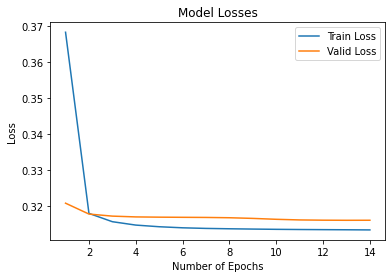

In [ ]:
# Model loss
epoch_ticks = range(1, n_epochs + 1)
plt.plot(epoch_ticks, train_losses)
plt.plot(epoch_ticks, valid_losses)
plt.legend(['Train Loss', 'Valid Loss'])
plt.title('Model Losses')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.savefig('SP_BoW_40k_batch1_lr6e_5_10kRW_baseline_Loss.png', dpi=my_dpi*10,
            bbox_inches='tight')
plt.show()

### BoW Performance

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1993
           1       1.00      0.99      0.99      2007

    accuracy                           0.99      4000
   macro avg       0.99      0.99      0.99      4000
weighted avg       0.99      0.99      0.99      4000



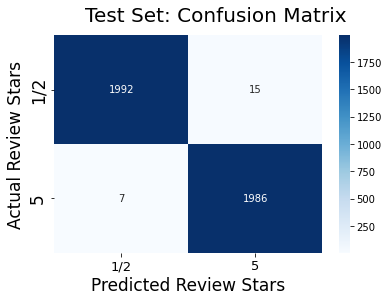

In [ ]:
# Determine model metrics
bow_model.eval()
test_accuracy, n_examples = 0, 0
y_true, y_pred = [], []
input_type = 'bow'

with torch.no_grad():
    for seq, bow, tfidf, target, text in test_loader:
        inputs = bow
        probs = bow_model(inputs)
        if input_type == 'tdidf':
            inputs = tfidf
            probs = tfidf_model(inputs)

        probs = probs.detach().cpu().numpy()
        predictions = np.argmax(probs, axis=1)
        target = target.cpu().numpy()

        y_true.extend(predictions)
        y_pred.extend(target)

print('Classification Report:')
print(classification_report(y_true, y_pred))

f, (ax) = plt.subplots(1,1)
f.suptitle('Test Set: Confusion Matrix', fontsize=20)
cm = confusion_matrix(y_true, y_pred, labels=[1,0])
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax=ax, cmap='Blues', fmt='d')
ax.set_xlabel('Predicted Review Stars', fontsize=17)
ax.set_ylabel('Actual Review Stars', fontsize=17)
ax.xaxis.set_ticklabels(['1/2', '5'], fontsize=13)
ax.yaxis.set_ticklabels(['1/2', '5'], fontsize=17)
f.savefig('SP_BoW_40K_batch1_lr6e_5_10kRW_testSet_CF.png',
          dpi=my_dpi*10, bbox_inches='tight')

**Examine a few examples**

In [ ]:
flatten = lambda x: [sublst for lst in x for sublst in lst]
seq_lst, bow_lst, tfidf_lst, target_lst, text_lst = zip(*test_loader)
seq_lst, bow_lst, tfidf_lst, target_lst, text_lst = map(flatten, [seq_lst,
                                                                  bow_lst,
                                                                  tfidf_lst,
                                                                  target_lst,
                                                                  text_lst])
test_examples = list(zip(seq_lst, bow_lst, tfidf_lst, target_lst, text_lst))

def print_random_prediction(model, n=5, input_type='bow'):
    to_emoji = lambda x: '😄' if x else '😡'
    model.eval()
    rows = []
    for i in range(n):
        with torch.no_grad():
            seq, bow, tdidf, target, text = random.choice(test_examples)
            target = target.item()

            inputs = bow
            if input_type == 'tdidf':
                inputs = tfidf

            probs = model([inputs])
            probs = probs.detach().cpu().numpy()
            prediction = np.argmax(probs, axis=1)[0]

            predicted = to_emoji(prediction)
            actual = to_emoji(target)

            row = f'''
            <tr>
            <td>{i+1}&nbsp;</td>
            <td>{text}&nbsp;</td>
            <td>{predicted}&nbsp;</td>
            <td>{actual}&nbsp;</td>
            </tr>
            '''
            rows.append(row)

    rows_joined = '\n'.join(rows)
    table = f'''
    <table>
    <tbody>
    <tr>
    <td><b>Number</b>&nbsp;</td>
    <td><b>Review</b>&nbsp;</td>
    <td><b>Predicted</b>&nbsp;</td>
    <td><b>Actual</b>&nbsp;</td>
    </tr>{rows_joined}
    </tbody>
    </table>
    '''
    display(HTML(table))

In [ ]:
print_random_prediction(bow_model, n=5, input_type='bow')

Number,Review,Predicted,Actual
1,today time melt order basic grilled cheese ordered pork sandwich waited minute get food complaint melt course wait time get food fact pork several small bone fry tasted like sat box armed receive meal free due bone meat based experience probably return disappointed since saw food network,😡,😡
2,went ihop pm waited hour order drink customer service bad drink wait minute order food bad customer service night,😡,😡
3,food pretty solid far authentic looking standard americanized chinese food throw thai food standouts general tsos chicken sesame chicken mongolian beef last visit tried thai curry pretty mediocre nice kick spice overall place forgettable need chinese fix definitely job,😡,😡
4,need change name place lowest quality seafood market talking high school cafeteria quality level price bad totally overpriced hard find seafood restaurant austin better getting frozen meal heb stuff,😡,😡
5,impeccable service outstanding seafood enjoyed chef choice sashimi phenomenal cowboy roll interesting tasty dragon role world people great may want call ahead lunch get little busy,😄,😄


## TF-IDF Model



### Initialize TF-IDF Model

In [ ]:
%cd /content/drive/MyDrive/Yelp_Reviews/Models/DL/TFIDF/SentimentPolarity/

In [ ]:
tfidf_model = FeedfowardTextClassifier(
    vocab_size=len(dataset.token2idx),
    hidden1=HIDDEN1,
    hidden2=HIDDEN2,
    num_labels=2,
    device=device,
    batch_size=BATCH_SIZE,
)
tfidf_model

FeedfowardTextClassifier(
  (fc1): Linear(in_features=10001, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=2, bias=True)
)

### Train TF-IDF Model

TF-IDF vectors as input

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, tfidf_model.parameters()),
    lr=LEARNING_RATE)

scheduler = CosineAnnealingLR(optimizer, 1)

In [ ]:
#  Save the general checkpoint
EPOCH = 1
OUT_DIR = './Models/40k_batch1_lr6e_5_10kRW_baseline.pt'
LOSS = 0.4

In [ ]:
n_epochs = 0
train_losses, valid_losses = [], []
while True:
    train_loss = train_epoch(tfidf_model, optimizer, train_loader,
                             input_type='tfidf')
    valid_loss = validate_epoch(tfidf_model, valid_loader, input_type='tfidf')

    tqdm.write(
        f'epoch #{n_epochs + 1:3d}\ttrain_loss: {train_loss:.2e}\tvalid_loss: {valid_loss:.2e}\n',
    )

    # Early stopping if the current valid_loss is greater than the last three valid losses
    if len(valid_losses) > 2 and all(valid_loss >= loss for loss in valid_losses[-3:]):
        print('Stopping early')
        break

    # Append loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    n_epochs += 1

epoch #  1	train_loss: 4.12e-01	valid_loss: 3.26e-01

epoch #  2	train_loss: 3.21e-01	valid_loss: 3.20e-01

epoch #  3	train_loss: 3.17e-01	valid_loss: 3.18e-01

epoch #  4	train_loss: 3.15e-01	valid_loss: 3.18e-01

epoch #  5	train_loss: 3.15e-01	valid_loss: 3.18e-01

epoch #  6	train_loss: 3.14e-01	valid_loss: 3.18e-01

epoch #  7	train_loss: 3.14e-01	valid_loss: 3.18e-01

epoch #  8	train_loss: 3.14e-01	valid_loss: 3.17e-01

epoch #  9	train_loss: 3.14e-01	valid_loss: 3.17e-01

epoch # 10	train_loss: 3.14e-01	valid_loss: 3.17e-01

epoch # 11	train_loss: 3.14e-01	valid_loss: 3.17e-01

epoch # 12	train_loss: 3.14e-01	valid_loss: 3.17e-01

epoch # 13	train_loss: 3.14e-01	valid_loss: 3.17e-01

epoch # 14	train_loss: 3.14e-01	valid_loss: 3.17e-01

epoch # 15	train_loss: 3.14e-01	valid_loss: 3.17e-01

epoch # 16	train_loss: 3.13e-01	valid_loss: 3.17e-01

epoch # 17	train_loss: 3.13e-01	valid_loss: 3.17e-01

epoch # 18	train_loss: 3.13e-01	valid_loss: 3.17e-01

epoch # 19	train_loss: 3.13e

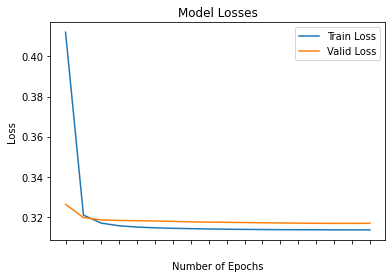

In [ ]:
# Model loss
epoch_ticks = range(1, n_epochs + 1)
plt.plot(epoch_ticks, train_losses)
plt.plot(epoch_ticks, valid_losses)
plt.legend(['Train Loss', 'Valid Loss'])
plt.title('Model Losses')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.xticks(epoch_ticks,color='w')
plt.savefig('SP_TFIDF_40k_batch1_lr6e_5_10kRW_baseline_Loss.png', dpi=my_dpi*10,
            bbox_inches='tight')
plt.show()

### TF-IDF Performance

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      2003
           1       0.99      0.99      0.99      1997

    accuracy                           0.99      4000
   macro avg       0.99      0.99      0.99      4000
weighted avg       0.99      0.99      0.99      4000



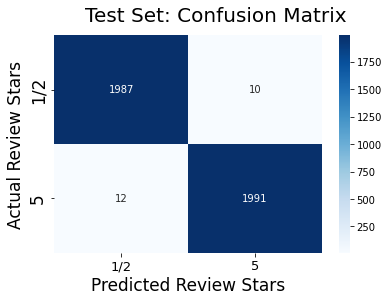

In [ ]:
# Determine model metrics
tfidf_model.eval()
test_accuracy, n_examples = 0, 0
y_true, y_pred = [], []

with torch.no_grad():
    for seq, bow, tfidf, target, text in test_loader:
        inputs = tfidf
        probs = tfidf_model(inputs)

        probs = probs.detach().cpu().numpy()
        predictions = np.argmax(probs, axis=1)
        target = target.cpu().numpy()

        y_true.extend(predictions)
        y_pred.extend(target)

print('Classification Report:')
print(classification_report(y_true, y_pred))

f, (ax) = plt.subplots(1,1)
f.suptitle('Test Set: Confusion Matrix', fontsize=20)
cm = confusion_matrix(y_true, y_pred, labels=[1,0])
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax=ax, cmap='Blues', fmt='d')
ax.set_xlabel('Predicted Review Stars', fontsize=17)
ax.set_ylabel('Actual Review Stars', fontsize=17)
ax.xaxis.set_ticklabels(['1/2', '5'], fontsize=13)
ax.yaxis.set_ticklabels(['1/2', '5'], fontsize=17)
f.savefig('SP_TFIDF_40K_batch1_lr6e_5_10kRW_testSet_CF.png',
          dpi=my_dpi*10, bbox_inches='tight')

In [ ]:
print_random_prediction(tfidf_model, n=5, input_type='tfidf')

Number,Review,Predicted,Actual
1,horrible way gate stopped togo side ordered burger started wait waiting one customer busy togo side minute yes minutes asked girl see much longer burger would get gate let know could wait couple minute would need get refund go girl counter care help communicate eta nothing staring blankly annoyed interrupting eating cheese fry hidden register like another planet one customer also perplexed give crap behavior get gate turn flight finally burger came couple minute later sloppily thrown box even closed bag grabbed burger ran gate plane open burger find pink middle fine hand made patty like frozen one come pack grocery store kind gross pink middle still cold want risk eating ate around edge threw rest away never go back wahlburgers really need evaluate staff working register girl bad business,😡,😡
2,one word delicious try orange chicken brown rice disappointed,😡,😡
3,minute walk know hit jackpot especially love desert red velvet perfect frosting ever bite yum,😄,😄
4,one best italian restaurant portland menu many option unique authentic flavor combination atmosphere contemporary fun great age service also fantastic highlight pepper light appetizer chicken bolognese entree sauce delicious,😄,😄
5,good curry fantastic sauce beef lamp tender juicy dish came small plate way finish service nice warm,😄,😄
